In [1]:
print("hi")

hi


In [539]:
from typing import Annotated

from langchain_google_genai import GoogleGenerativeAI, ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import DuckDuckGoSearchResults  # for more search result
from langchain_community.tools import DuckDuckGoSearchRun

from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display
from typing_extensions import TypedDict

from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY  = os.getenv("GOOGLE_API_KEY")

tavily_api_key = os.getenv("Tavily_API_KEY")
print("Tavily API Key:", os.getenv("TAVILY_API_KEY"))

Tavily API Key: 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


In [540]:
from langchain_groq import ChatGroq
llm = ChatGroq(   # poetry add langchain-groq
    # model= "Gemma2-9b-It"
    model="Llama3-8b-8192",
    temperature=0,
    stop_sequences=""
    
)

In [541]:

# llm = llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-flash",
#     temperature=0.2
# )

In [542]:
response = llm.invoke("what is langgraph")
response

AIMessage(content='LangGraph is a fascinating topic!\n\nLangGraph is a type of graph-based language model that represents language as a network of nodes and edges. In a LangGraph, each node represents a word, phrase, or concept, and the edges between nodes capture the relationships between them, such as semantic similarity, co-occurrence, or grammatical dependencies.\n\nThe LangGraph approach is inspired by the idea that language is a complex network of interconnected concepts, and by modeling language as a graph, researchers can capture the intricate relationships between words, phrases, and ideas. This can lead to improved language understanding, generation, and processing capabilities.\n\nSome key features of LangGraphs include:\n\n1. **Node representation**: Each node in the graph represents a word, phrase, or concept, and is typically associated with a set of features, such as word embeddings, part-of-speech tags, or named entity recognition labels.\n2. **Edge representation**: Th

In [543]:
def multiply(a:int, b:int):
    """
    Multiply a and b
    Args:
      a: first int
      b: second int
    """
    return a*b

In [544]:
def add(a:int, b:int):
    """
    add a and b
    Args:
      a: first int
      b: second int
    """
    return a+b

In [545]:
def divide(a:int, b:int):
    """
    divide a and b
    Args:
      a: first int
      b: second int
    """
    return a/b

In [546]:
# search = TavilySearchResults(
#     max_results=5,
#     search_depth="advanced",
#     include_answer=True,
#     # include_raw_content=True,
#     # include_images=True,
#     )

In [547]:
# search = DuckDuckGoSearchRun()

In [548]:
search = DuckDuckGoSearchResults()

In [549]:
search.invoke("who is a current president of USA? ")

"snippet: The White House, official residence of the president of the United States, in July 2008. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of ..., title: List of presidents of the United States - Wikipedia, link: https://en.wikipedia.org/wiki/List_of_Presidents_of_the_United_States, snippet: The president of the United States is the: U.S. head of state; Chief executive of the federal government; Commander-in-Chief of the armed forces; Current president. The 47th and current president of the United States is Donald John Trump. He was sworn into office on January 20, 2025. Former U.S. presidents. The United States has had 46 former U ..., title: Presidents, vice presidents, and first ladies - USAGov, link: https://www.usa.gov/pr

In [550]:
tools = [search]

In [551]:
llm_with_tools = llm.bind_tools(tools)

In [552]:
llm_with_tools.invoke("who is a current president of USA? ")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rnz0', 'function': {'arguments': '{"query":"who is the current president of the USA"}', 'name': 'duckduckgo_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 76, 'prompt_tokens': 1906, 'total_tokens': 1982, 'completion_time': 0.063333333, 'prompt_time': 0.23955643, 'queue_time': -0.29830878699999996, 'total_time': 0.302889763}, 'model_name': 'Llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dad74783-51bf-4050-9372-b253abce6a02-0', tool_calls=[{'name': 'duckduckgo_results_json', 'args': {'query': 'who is the current president of the USA'}, 'id': 'call_rnz0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1906, 'output_tokens': 76, 'total_tokens': 1982})

In [553]:
# sys message
sys_msg = SystemMessage(content="you are a helpful assistant tasked with using search and performing arithmatic operation ")

In [554]:
def reasoner(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [555]:
graph_builder = StateGraph(MessagesState)

# add nodes
graph_builder.add_node("reasoner", reasoner)
graph_builder.add_node("tools", ToolNode(tools))

# add ages
graph_builder.add_edge(START, "reasoner")
graph_builder.add_conditional_edges("reasoner", tools_condition)
graph_builder.add_edge("tools","reasoner" )
graph = graph_builder.compile()

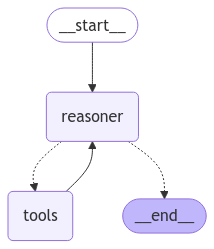

In [556]:
# display the graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [557]:
def stream_graph_update(user_input:str):
    # state = {"messages":[{"role":"user", "content":user_input}]}
    state = {"messages":[user_input]}
    config = {"configurable": {"thread_id": "1"}}
    # config = {"configurable": {"thread_id": "1", "user_id": "1"}} # try this
    
    for event in graph.stream(state, config,):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [559]:
# generating response
response = stream_graph_update("who is a current president of Pakistan? ")
print(response)

Assistant: 
Assistant: snippet: Asif Ali Zardari is the current and 14th president of Pakistan since 2024, and the widower of former prime minister Benazir Bhutto. He was also the 11th president from 2008 to 2013, and the co-chairperson of Pakistan People's Party from 2007 to 2015., title: Asif Ali Zardari - Wikipedia, link: https://en.wikipedia.org/wiki/Asif_Ali_Zardari, snippet: Pakistan Peoples Party's co-chairperson Asif Ali Zardari has won a second term as Pakistan's president, supported by the ruling coalition in a vote by parliament and regional assemblies ..., title: Asif Ali Zardari elected Pakistan's president for second time, link: https://www.aljazeera.com/news/2024/3/9/asif-ali-zardari-elected-pakistans-president-for-second-time, snippet: Supporters Pakistan People's Party offer sweets to each other as they celebrate their leader Asif Ali Zardari elect as Pakistan's President, in Lahore, Pakistan, Saturday, March 9, 2023. Pakistan's lawmakers have chosen Zardari as the cou